## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, fuse_tokenized_corpus, chunk_corpus

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import split_on_value



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.keras.mixed_precision.set_global_policy('mixed_float16')

Num GPUs Available:  1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080, compute capability 8.9


In [2]:
tokenizer = pkl.load(open("tokenizers/tokenizer_superQA_24k.pkl", "rb"))
tokenizer.create_hash()
tokenizer.add_special_tokens(["<s>", "</s>", "<q>", "<a>","<pad>"])

In [3]:
def batch(corpus, batch_size=32):
    length = corpus.shape[1]

    batches = length // batch_size

    corpus = corpus[:, :batches * batch_size]

    corpus = tf.reshape(corpus, [-1, batch_size])
    return corpus


In [4]:
corpus_coqa_sqa = pkl.load(open('corpus/corpus_coqa_sqa_24k_padded', 'rb'))
corpus_squad_sqa = pkl.load(open("corpus/corpus_squad_sqa_24k_padded", 'rb'))

corpus_web_qa = pkl.load(open("corpus/corpus_web_qa_24k", 'rb'))
corpus_web_qa = batch(corpus_web_qa, batch_size=768)

corpus_web_article = pkl.load(open("corpus/corpus_web_article_24k", 'rb'))
corpus_web_article = batch(corpus_web_article, batch_size=768)

corpus_wiki_qa = pkl.load(open("corpus/corpus_wiki_qa_24k", 'rb'))
corpus_wiki_qa = batch(corpus_wiki_qa, batch_size=768)

corpus_wiki_article = pkl.load(open("corpus/corpus_wiki_article_24k", 'rb'))
corpus_wiki_article = batch(corpus_wiki_article, batch_size=768)


In [5]:
print(corpus_coqa_sqa.shape)
print(corpus_squad_sqa.shape)
print(corpus_web_qa.shape)
print(corpus_web_article.shape)
print(corpus_wiki_qa.shape)
print(corpus_wiki_article.shape)

(7199, 768)
(19035, 768)
(2495, 768)
(21710, 768)
(2026, 768)
(26420, 768)


In [6]:
print(np.sum(corpus_coqa_sqa[:100]==-1))
print(np.sum(corpus_squad_sqa[:100]==-1))
print(np.sum(corpus_web_qa[:100]==-1))
print(np.sum(corpus_web_article[:100]==-1))
print(np.sum(corpus_wiki_qa[:100]==-1))
print(np.sum(corpus_wiki_article[:100]==-1))

0
0
0
0
0
0


In [7]:
corpus = tf.concat([corpus_coqa_sqa, corpus_squad_sqa, corpus_web_qa, corpus_web_article, corpus_wiki_qa, corpus_wiki_article], axis=0)

tf.random.set_seed(42)
corpus = tf.random.shuffle(corpus)
length = corpus.shape[0]
ratio = int(length * 0.95)

corpus_train = corpus[:ratio] 
corpus_test = corpus[ratio:]

print(length*768)

60583680


In [8]:
def data_pipeline(corpus, batch_size=32):
    samples = corpus.shape[0]

    steps_per_epoch = samples // batch_size
    
    ds = tf.data.Dataset.from_tensor_slices(corpus)
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=100*batch_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    
    return ds, steps_per_epoch

In [9]:
ds_train, steps_per_epoch = data_pipeline(corpus_train, batch_size=8)
ds_test,_ = data_pipeline(corpus_test, batch_size=1)

In [10]:
steps_per_epoch

9367

## Define Model

In [11]:
initial_lr = 1e-4
decay_steps = 20000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 1000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 768
embed_dim = 768#896
tf_blocks = 12#14
heads = 12#14
ff_dim = 4*embed_dim
weight_decay = 0.01
dropout = 0.1

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    tokenizer=tokenizer,
                    lr=lr_schedule,
                    wd = weight_decay,
                    dropout=dropout,
                    accum_steps=3,
                    )

losses_train = []
losses_test = []


In [12]:
name = "model_super_qa"

ckpt = tf.train.Checkpoint(
    optimizer=model.opt,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [13]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [14]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 104145707


In [27]:
def train_loop(iter_train, iter_test, steps_per_epoch, epochs):
    for i in tqdm(range(steps_per_epoch*epochs)):
        batch_train = next(iter_train)
        batch_test = next(iter_test)
        
        loss_train = model.train_step(batch_train).numpy()
        losses_train.append(loss_train)
        
        loss_test = model.evaluate(batch_test).numpy()
        losses_test.append(loss_test)

        if (i+1) % 1000 == 0:
            ckpt_manager.save()
            pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

        lr = model.opt.inner_optimizer._decayed_lr(tf.float32).numpy()
        print(np.mean(losses_train[-3:]), np.mean(losses_test[-3:]), lr)
    return losses_train, losses_test

In [25]:
iter_train = iter(ds_train)
iter_test = iter(ds_test)

In [35]:
train_loop(iter_train, iter_test, steps_per_epoch, 10)

  0%|          | 0/93670 [00:00<?, ?it/s]

3.651453 3.9714196 3.8640883e-05
3.6517365 3.9551308 3.8639544e-05
3.70537 3.9309483 3.8639544e-05
3.699258 3.7861497 3.8639544e-05
3.5362709 3.7142696 3.86382e-05
3.5493104 3.5961955 3.86382e-05
3.4371738 3.5358593 3.86382e-05
3.5294282 3.5504093 3.8636867e-05
3.4479115 3.7573826 3.8636867e-05
3.5714293 3.793278 3.8636867e-05
3.6043987 3.728831 3.8635528e-05
3.5551472 3.7001083 3.8635528e-05
3.590063 3.9176552 3.8635528e-05
3.7462661 4.1596646 3.8634185e-05
3.6621287 3.5267572 3.8634185e-05
3.7668 3.422467 3.8634185e-05
3.5831115 3.2752678 3.863285e-05
3.5911455 3.904638 3.863285e-05
3.2907238 3.9021914 3.863285e-05
3.1882188 4.1403155 3.863151e-05
3.4080355 4.2489524 3.863151e-05
3.5913992 4.3713965 3.863151e-05
3.7095375 4.070661 3.8630173e-05
3.4901857 3.7967758 3.8630173e-05
3.4891691 3.2717812 3.8630173e-05
3.5973303 3.3006124 3.8628834e-05
3.67966 3.524645 3.8628834e-05
3.692565 3.9822903 3.8628834e-05
3.597702 3.7028015 3.8627488e-05
3.5463514 3.5749958 3.8627488e-05
3.529745 3

KeyboardInterrupt: 

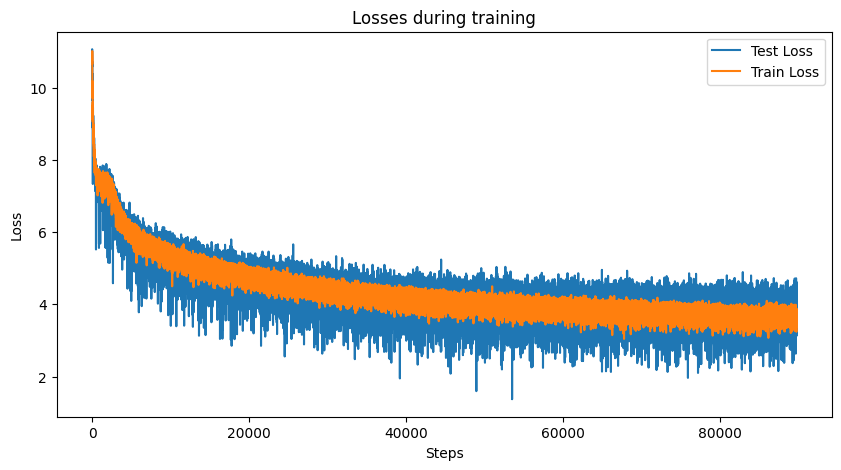

In [36]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.figure(figsize=(10, 5))
plt.plot(moving_average(losses_test[100:]), label="Test Loss")
plt.plot(moving_average(losses_train[100:]), label="Train Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Losses during training")
plt.legend()
plt.show()

In [37]:
import textwrap
import ipywidgets as widgets
from IPython.display import display

text = "<s>John was in the house. After breakfast, he went to London high school. " \
"Sarah didn't want to go to school, so she stayed in the garden. There she found a pretty butterfly.<q>Where did john go?<a>"
text = text.lower()
tokens = tf.cast(tokenizer.encode(text), tf.int32)
print(tokens)

T = 1
#tf.random.set_seed(42)
wrapper = textwrap.TextWrapper(width=80)

# create a read-only text area
ta = widgets.Textarea(
    value="",
    layout=widgets.Layout(width='80ch', height='20em'),
    disabled=True
)
display(ta)

for i in range(1024):
    logits = model.call(tokens)[0, -1:]
    idx = tf.cast(
        tf.random.categorical(logits / T, num_samples=1),
        tf.int32
    ) 
    tokens = tf.concat([tokens, idx], axis=1)

    text_pred = (
        tokenizer
        .decode(tokens)
        .numpy()[0]
        .decode('utf-8')
        .replace("\n", " ")
    )
    ta.value = wrapper.fill(text_pred)  # this updates in-place

    if idx[0, 0] == tokenizer.token_to_idx["</s>"]:
        break

tf.Tensor(
[[24102  8639   170   125   106   939    37   406  8371    35   174  1732
    138  1036   706   875    37  7823  3781  1533   138   348   138   875
     35   477   427  8151   125   106  4314    37   454   427   671   103
   7857 14846    37 24104  2992   416   720   348    54 24105]], shape=(1, 46), dtype=int32)


Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

KeyboardInterrupt: 